## Семинар 3: Q-обучение
### Майнор ВШЭ, 31.01.2019

Одним из наиболее популярных алгоритм обучения на основе временных различий является Q-обучение. Агент, который принимает решения на основе $Q$-функции, не требует модель для обучения и выбора действий, т.е. такой агент также свободен от модели (model-free), как и TD-агент. Уравнение Беллмана для значения Q-функции в равновесии записывается как

$$Q(s,a)=r(s)+\gamma\sum_s'T(s,a,s')\max_{a'}Q(a',s').$$

Уравнение для итерационного обновления значений Q-функции выглядит следующим образом:

$$Q(s,a)\leftarrow Q(s,a)+\alpha(r(s)+\gamma\max_{a'}Q(a',s') - Q(s,a)).$$

---
QLearningAgent($s', r'$):
	
$\quad$ Глобальные переменные:

$\quad$ $MDP=<S,T,r,\gamma>$ - задача МПР

$\quad$ $Q\leftarrow [0,\dots];$ - таблица значений полезности действий

$\quad$ $N_{sa}\leftarrow [0,\dots];$ - таблица частот пар <<состояние-действие>>
			
`1.` $s\leftarrow\varnothing,a\leftarrow\varnothing,r\leftarrow\varnothing$;
			
`2.` Если $s\not=\varnothing$, то

`3.` $\quad N_{sa}[s,a] += 1$;

`4.` $\quad  Q[s,a]\leftarrow Q(s,a) + \alpha({N_{sa}[s,a]})(r + \gamma\max_{a'} Q[a',s']-Q[s,a])$

`5.` Если $s'$ - конечное, то

`6.` $\quad s\leftarrow\varnothing,a\leftarrow\varnothing,r\leftarrow\varnothing$;

`7.` иначе
	
`8.` $\quad s\leftarrow s',a\leftarrow argmax_{a'}f(Q[a',s'],N_{sa}[a',s']), r\leftarrow r'$;

`9.` вернуть $a$

---

### Задание 1
Оформим этот алгоритм в виде класса QLearningAgent

In [49]:
import random, math

import numpy as np
from collections import defaultdict

class QLearningAgent():
    """
    Q-Learning Agent

    Instance variables you have access to
      - self.epsilon (exploration prob)
      - self.alpha (learning rate)
      - self.discount (discount rate aka gamma)

    Functions you should use
      - self.getLegalActions(state)
        which returns legal actions for a state
      - self.getQValue(state,action)
        which returns Q(state,action)
      - self.setQValue(state,action,value)
        which sets Q(state,action) := value

    !!!Important!!!
    NOTE: please avoid using self._qValues directly to make code cleaner
    """
    def __init__(self,alpha,epsilon,discount,getLegalActions):
        "We initialize agent and Q-values here."
        self.getLegalActions= getLegalActions
        self._qValues = defaultdict(lambda:defaultdict(lambda:0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def getQValue(self, state, action):
        """
          Returns Q(state,action)
        """
        return self._qValues[state][action]

    def setQValue(self,state,action,value):
        """
          Sets the Qvalue for [state,action] to the given value
        """
        self._qValues[state][action] = value

Добавим нашему агенту возможность вычислять оценки $V$:

In [50]:
def getValue(self, state):
    """
      Returns max_action Q(state,action)
      where the max is over legal actions.
    """
    
    possibleActions = self.getLegalActions(state)
    #If there are no legal actions, return 0.0
    if len(possibleActions) == 0:
        return 0.0

    ### Здесь ваш код ###
    value = max([self.getQValue(state,action) for action in possibleActions])
    return value

QLearningAgent.getValue =  getValue

Стратегия нашего агента будет заключаться в выборе лучшего действия, в соответствии с оценками $Q$:

In [51]:
def getPolicy(self, state):
    """
      Compute the best action to take in a state. 
      
    """
    possibleActions = self.getLegalActions(state)

    #If there are no legal actions, return None
    if len(possibleActions) == 0:
        return None
    
    best_action = None
    ### Здесь ваш код ###
    for action in possibleActions:
        if best_action is None:
            best_action = action
        else:
            if self.getQValue(state,action) > self.getQValue(state,best_action):
                best_action = action
    return best_action

QLearningAgent.getPolicy = getPolicy

Для конкретной ситуации мы будем выбирать действие, используя $\epsilon$-жадный подход:

In [59]:
def getAction(self, state):
    """
      Compute the action to take in the current state, including exploration.  
      
      With probability self.epsilon, we should take a random action.
      otherwise - the best policy action (self.getPolicy).

    """
    
    # Pick Action
    possibleActions = self.getLegalActions(state)

    action = None
    #If there are no legal actions, return None
    if len(possibleActions) == 0:
        return action
    action = np.random.choice([self.getPolicy(state),np.random.choice(possibleActions)],p = [1 - self.epsilon,self.epsilon])
    ### Здесь ваш код ###
    
    return action

QLearningAgent.getAction = getAction

$$Q(s,a)\leftarrow Q(s,a)+\alpha(r(s)+\gamma\max_{a'}Q(a',s') - Q(s,a)).$$

In [60]:
def update(self, state, action, nextState, reward):
    """
      You should do your Q-Value update here

      NOTE: You should never call this function,
      it will be called on your behalf
    

    """
    value = self.getQValue(state,action) + self.alpha * (reward + self.discount * self.getValue(nextState) - self.getQValue(state,action))
    self.setQValue(state,action,value)
    #reference_qvalue = <the "correct state value", uses reward and the value of next state>
    ### Здесь ваш код ###
    pass
    
QLearningAgent.update = update

Тестируем нашего агента на задаче Taxi

In [61]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

In [62]:
agent = QLearningAgent(alpha=0.7, epsilon=0.5, discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

In [63]:
assert 'getPolicy' in dir(agent)

In [64]:
def play_and_train(env, agent, t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        #a = <get agent to pick action given state s>
        ### Здесь ваш код ###
        a = agent.getAction(s)
        next_s, r, done, _ = env.step(a)
        
        #<train(update) agent for state s>
        ### Здесь ваш код ###
        agent.update(s,a,next_s,r)
        s = next_s
        total_reward +=r
        if done:
            break
        
    return total_reward

eps = 0.1 mean reward = 5.8
alpha= 0.1


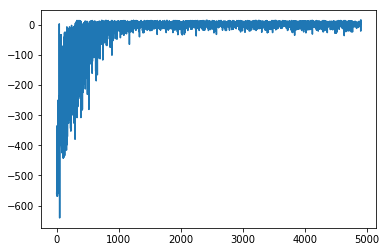

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

agent = QLearningAgent(alpha=0.5, epsilon=0.1, discount=0.9,
                       getLegalActions = lambda s: range(n_actions))

rewards = []
for i in range(5000):
    rewards.append(play_and_train(env, agent))
    if i % 900 == 0:
        agent.alpha = 0.1
#         agent.epsilon *= 0.9
#         agent.alpha *= 0.9
    if i % 100 == 0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        print("alpha=", agent.alpha)
        plt.plot(rewards)
        plt.show()

### Задание 2

Рассмотрим задачу CartPole. Это окружение имеет непрерывное множество состояний - попробуем их сгруппировать. Для этого попробуем использовать `round(x, n_digits)` для округления действительных чисел.

first state:[ 0.04967326  0.02587294  0.0432633  -0.00113704]


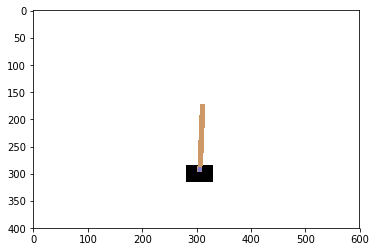

In [222]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n

print("first state:%s" % (env.reset()))
plt.imshow(env.render('rgb_array'))

In [223]:
env.close()

Оценим распределение наблюдений -- сыграем несколько эпизодов и запишем состояния.

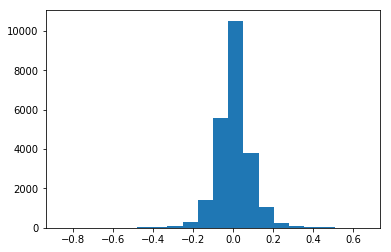

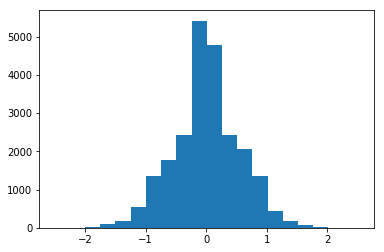

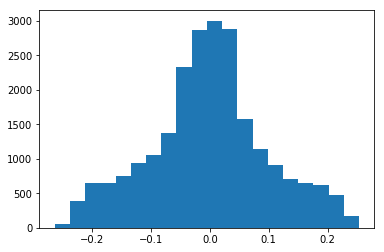

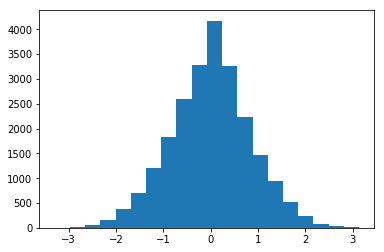

In [224]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()

Теперь создадим обертку для окружения, которая будет бинаризовать состояния:

In [225]:
from gym.core import ObservationWrapper


class Binarizer(ObservationWrapper):

    def _observation(self, state):

        # state = <round state to some amount digits.>
        # hint: you can do that with round(x,n_digits)
        # you will need to pick a different n_digits for each dimension
        ### Здесь ваш код ###

        return tuple(state)

In [226]:
env = Binarizer(gym.make("CartPole-v0"))

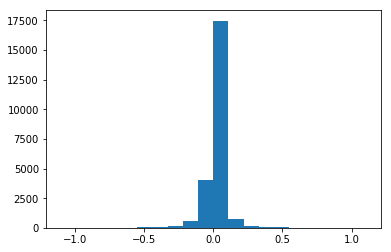

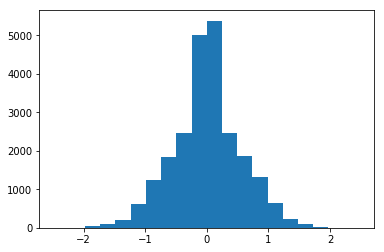

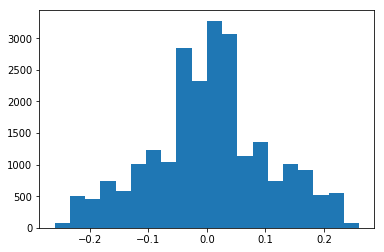

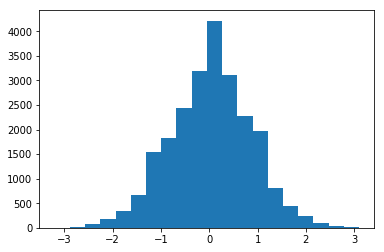

In [227]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):

    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()

Теперь обучним нашего Q-агента:

* Если бинаризация слишком грубая, агент может не обучаться.
* Если бинаризация слишком точная, сходимость процесса обучения может занять сущственно больше 1000 шагов.
* Размернсоть в 10^3 - 10^4 состояний (`len(QLearningAgent._qvalues)`) - оптимальная.
* Хорошим является агент, получаюший вознаграждение >= 50.

In [228]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       getLegalActions=lambda s: range(n_actions))

eps = 0.25 mean reward = 15.0


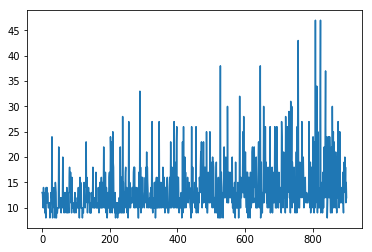

In [229]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))

    # OPTIONAL YOUR CODE: adjust epsilon
    if i % 100 == 0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()